# Feature Engineering

I aim to engineer features that will be part of the feature vector for each image. These will include:
- geometric elements (`elements_df`):
    - relative size of the main subject in the photo: what are of the image does the annotated box occupy?
    - horizontal placement of the subject: how far to the left or right is the subject located?
    - vertical placement of the subject: how far to the top or bottom is the subject located?
    - number of leading lines (horizontal, vertical, diagonal)
    - average angle of leading lines relative to horizontal axis
    - average length of leading lines
    - positions of leading lines relative to subject
- scene class (`scenes_df`): landscape, cityscape, human, animal, etc.
- composition attributes annotations (`attributes_df`):
    - proper exposure
    - vivid color
    - color harmony
    - object emphasis
    - balancing elements
    - symmetry
    - repetition
    - rule of thirds
    - motion blur
    - shallow depth of field

It's important to note that these features come from the human-annotated dataset, but the authors of the original CADB paper created a deep learning model that can predict many of these features for a new image. Due to this, the approach can be generalized to new images without requiring it to be manually reviewed and annotated by humans.   

These features will form a multi-dimensional manifold representation for images which I will aim to reduce to a lower-dimensional space to extract patterns and clusters related to compositional success scores (`scores_df`) assigned by the human data annotators. This constitutes a novel approach in my project, as I extend the methods proposed for analyzing image composition in the CADB paper by adding geometric representation learning to it.

## Setup

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import ast

# Setting up the aesthetic style of the plots
# sns.set_theme(style='whitegrid')


/Users/vlad_ivanchuk/opt/anaconda3/envs/cs109a/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Merging

In [2]:
attributes_df = pd.read_csv('../data/preprocessed/attributes_df.csv')
elements_df = pd.read_csv('../data/preprocessed/elements_df.csv')
scenes_df = pd.read_csv('../data/preprocessed/scenes_df.csv')
scores_df = pd.read_csv('../data/preprocessed/scores_df.csv')

In [3]:
combined_df = pd.merge(pd.merge(pd.merge(attributes_df, elements_df, on='img'), scenes_df, on='img'), scores_df, on='img')
combined_df.head(20)

img  exposure  symmetry  object_emphasis  score  rule_of_thirds  \
0   10012.jpg       0.2       0.0              0.0   0.55             0.0   
1   10016.jpg       0.0       0.0              0.4   0.60             0.4   
2   10022.jpg      -0.2       0.0             -0.2   0.45             0.2   
3    1004.jpg       0.4       0.0             -0.2   0.45            -0.4   
4    1005.jpg       0.0       0.0             -0.8   0.35             0.2   
5   10054.jpg       0.4       0.0             -0.2   0.70             0.0   
6   10071.jpg       0.0       0.0              0.4   0.70             0.8   
7   10090.jpg      -0.8       0.0              0.0   0.30             0.4   
8   10121.jpg       0.0       0.0              0.2   0.45            -0.2   
9   10122.jpg       0.0       0.0              0.4   0.65            -0.2   
10  10131.jpg       0.2       0.0              0.6   0.55             0.4   
11  10140.jpg       0.4       0.2             -0.4   0.60             0.2   
12   1015.jpg      -0.2       0.0              0.2   0.55             0.4   
13  10160.jpg       0.2       0.0              0.8   0.55             0.4   
14   1038.jpg      -0.2       0.0             -0.2   0.45            -0.2   
15   1046.jpg      -0.2       0.0              0.0   0.55             0.0   
16   1067.jpg       0.4       0.0             -1.0   0.35            -0.2   
17   1082.jpg      -0.2       0.0              0.0   0.55             0.0   
18   1089.jpg       0.2       0.0              0.0   0.75             0.6   
19   1102.jpg       0.2       0.0              0.2   0.50             0.0   

    repetition  balancing_elements  color_harmony  motion_blur  ...  \
0          0.0                -0.2            0.0          0.0  ...   
1          0.0                 0.0            0.2          0.0  ...   
2          0.0                 0.0            0.2          0.0  ...   
3          0.0                 0.0            0.6          0.0  ...   
4          0.0                 0.0            0.2          0.0  ...   
5          0.0                 0.4            0.8          0.0  ...   
6          0.0                 0.2            0.6          0.0  ...   
7          0.2                 0.0           -0.2          0.0  ...   
8          0.0                 0.2            0.0          0.0  ...   
9          0.0                 0.0            0.2          0.0  ...   
10         0.0                 0.0            0.0          0.0  ...   
11         0.2                 0.2            0.4          0.0  ...   
12         0.0                 0.0            0.0          0.0  ...   
13         0.0                 0.0            0.0          0.0  ...   
14         0.0                 0.0            0.0          0.0  ...   
15         0.0                 0.4            0.4          0.0  ...   
16         0.2                -0.2            0.0          0.0  ...   
17         0.0                 0.2            0.2         -0.2  ...   
18         0.0                 0.4            0.4          0.0  ...   
19         0.2                 0.0            0.0          0.0  ...   

    vanishing_point  fill_the_frame  radial none rule_of_thirds_x1  \
0               NaN             NaN     NaN  NaN               418   
1               NaN             NaN     NaN  NaN                83   
2               NaN             NaN     NaN  NaN               324   
3               NaN             NaN     NaN  NaN               591   
4               NaN             NaN     NaN  NaN               671   
5               NaN             NaN     NaN  NaN               499   
6               NaN             NaN     NaN  NaN               527   
7               NaN             NaN     NaN  NaN                82   
8               NaN             NaN     NaN  NaN                60   
9               NaN             NaN     NaN  NaN               441   
10              NaN             NaN     NaN  NaN               505   
11              NaN             NaN     NaN  NaN            

## Creating Features

In [4]:
# Initialize the dataframe to be filled by embedding features
features_df = combined_df[["img"]]
features_df.head(10)

img
0  10012.jpg
1  10016.jpg
2  10022.jpg
3   1004.jpg
4   1005.jpg
5  10054.jpg
6  10071.jpg
7  10090.jpg
8  10121.jpg
9  10122.jpg

### Geometric elements

#### Image size

In [5]:
# Define a function to get image dimensions
def get_image_dimensions(filename):
    with Image.open(filename) as img:
        return img.size  # returns a tuple (width, height)

# Path to the images directory
image_directory = '../data/CADB_Dataset/images/'

# Adding new columns for image 'height' and 'width'
combined_df['height'] = 0
combined_df['width'] = 0

# Fill in the dimensions
for index, row in combined_df.iterrows():
    file_path = f"{image_directory}{row['img']}"
    try:
        dimensions = get_image_dimensions(file_path)
        combined_df.at[index, 'width'], combined_df.at[index, 'height'] = dimensions
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

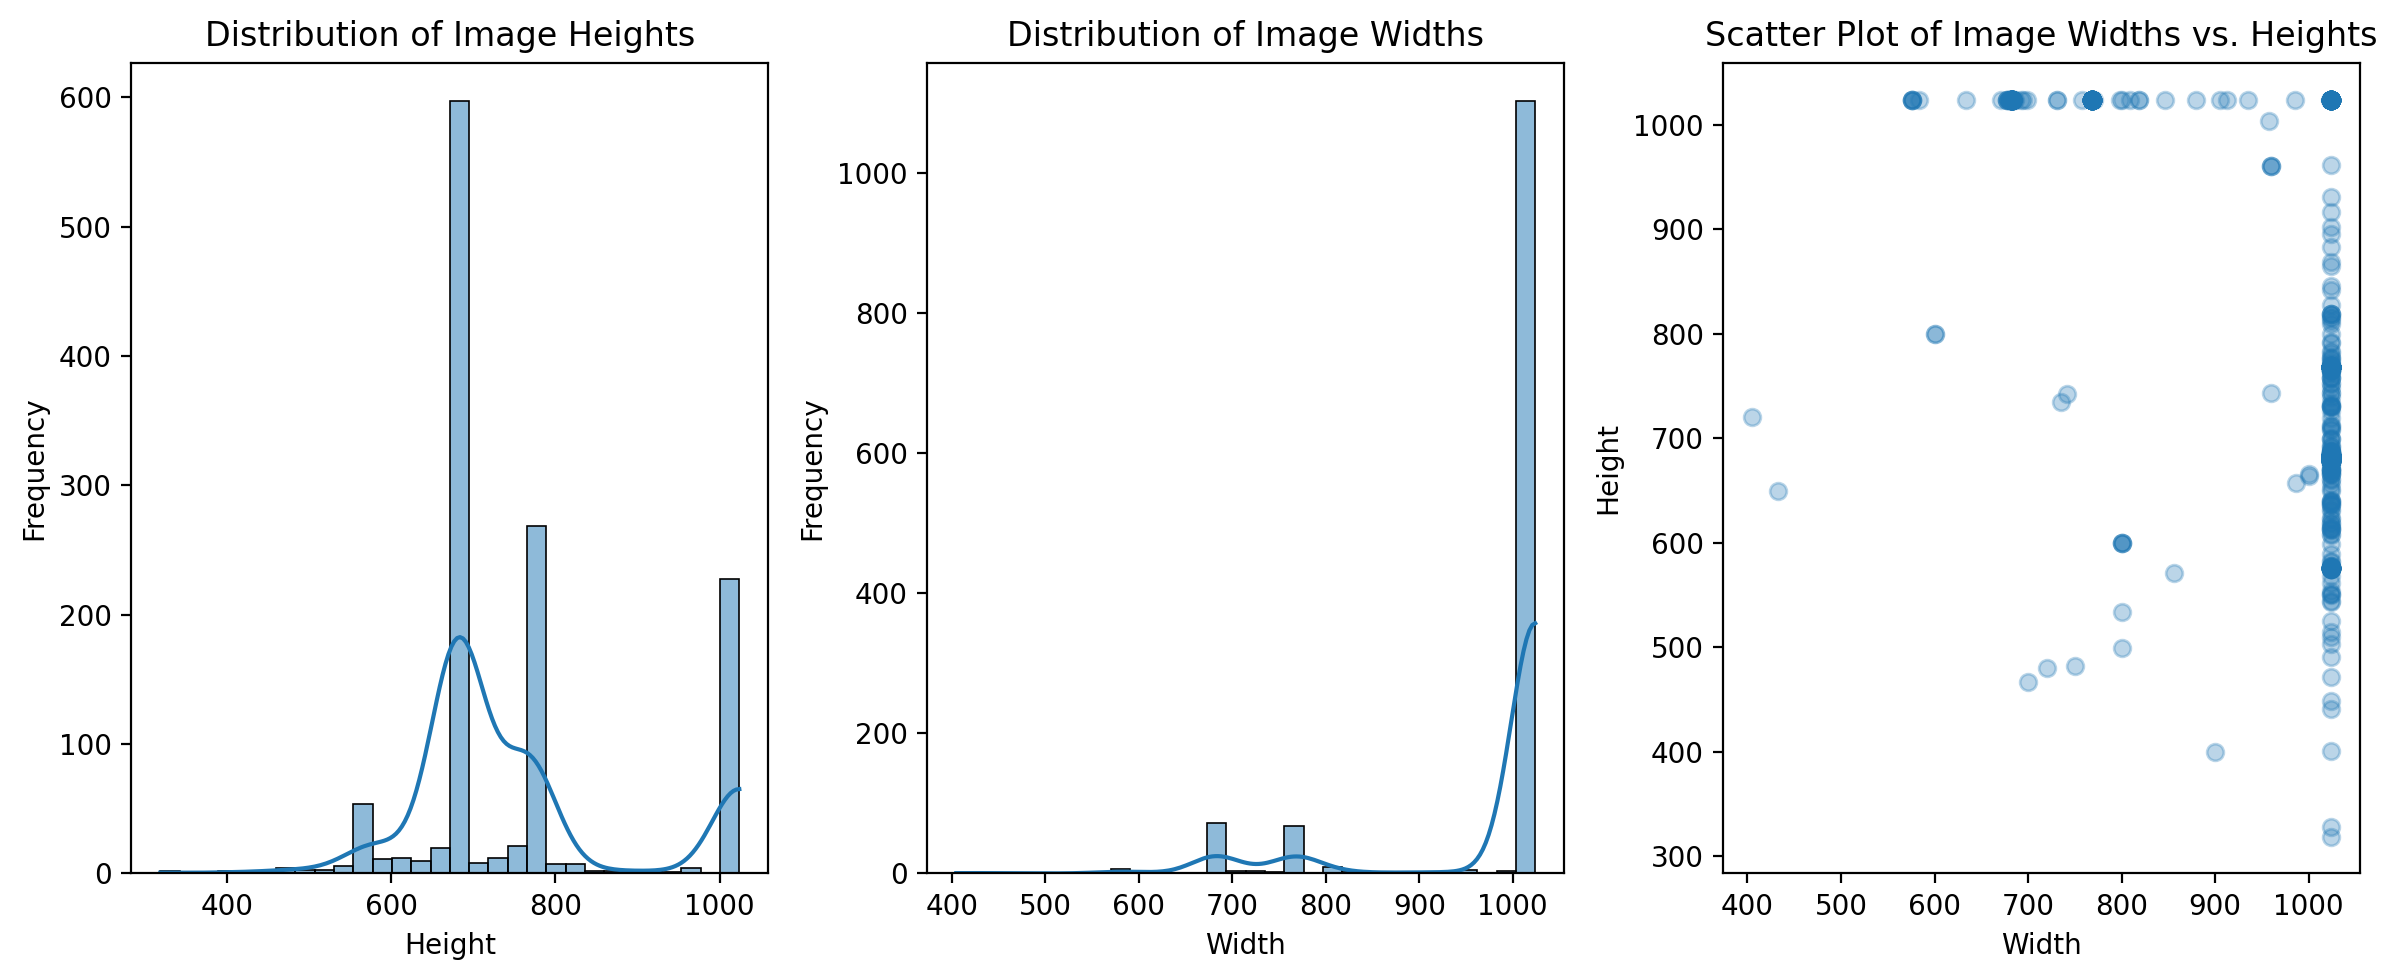

In [6]:
# Plot the distributions of image heights and widths
fig, ax = plt.subplots(1, 3, figsize=(12, 5), dpi=200)

# Plotting the distribution of heights
sns.histplot(combined_df['height'], bins=30, ax=ax[0], kde=True)
ax[0].set_title('Distribution of Image Heights')
ax[0].set_xlabel('Height')
ax[0].set_ylabel('Frequency')

# Plotting the distribution of widths
sns.histplot(combined_df['width'], bins=30, ax=ax[1], kde=True)
ax[1].set_title('Distribution of Image Widths')
ax[1].set_xlabel('Width')
ax[1].set_ylabel('Frequency')

# Create a scatter plot
ax[2].scatter(combined_df['width'], combined_df['height'], alpha=0.3)  # Setting transparency with alpha
ax[2].set_title('Scatter Plot of Image Widths vs. Heights')
ax[2].set_xlabel('Width')
ax[2].set_ylabel('Height')
ax[2].grid(False) 

# Display the plots
plt.tight_layout()
plt.show()


In [7]:
# Display features that will be used to create geometric embedding features (relative size of subject's bounding box,
# relative horizontal and vertical positions in the image)
combined_df[["img", "width", "height", "rule_of_thirds_x1", "rule_of_thirds_x2", "rule_of_thirds_y1", "rule_of_thirds_y2"]].head(5)

img  width  height  rule_of_thirds_x1  rule_of_thirds_x2  \
0  10012.jpg    683    1024                418                596   
1  10016.jpg   1024     683                 83                503   
2  10022.jpg   1024     678                324                366   
3   1004.jpg   1024     683                591                997   
4   1005.jpg   1024     683                671               1023   

   rule_of_thirds_y1  rule_of_thirds_y2  
0                274                934  
1                 63                588  
2                379                459  
3                 32                614  
4                 53                634

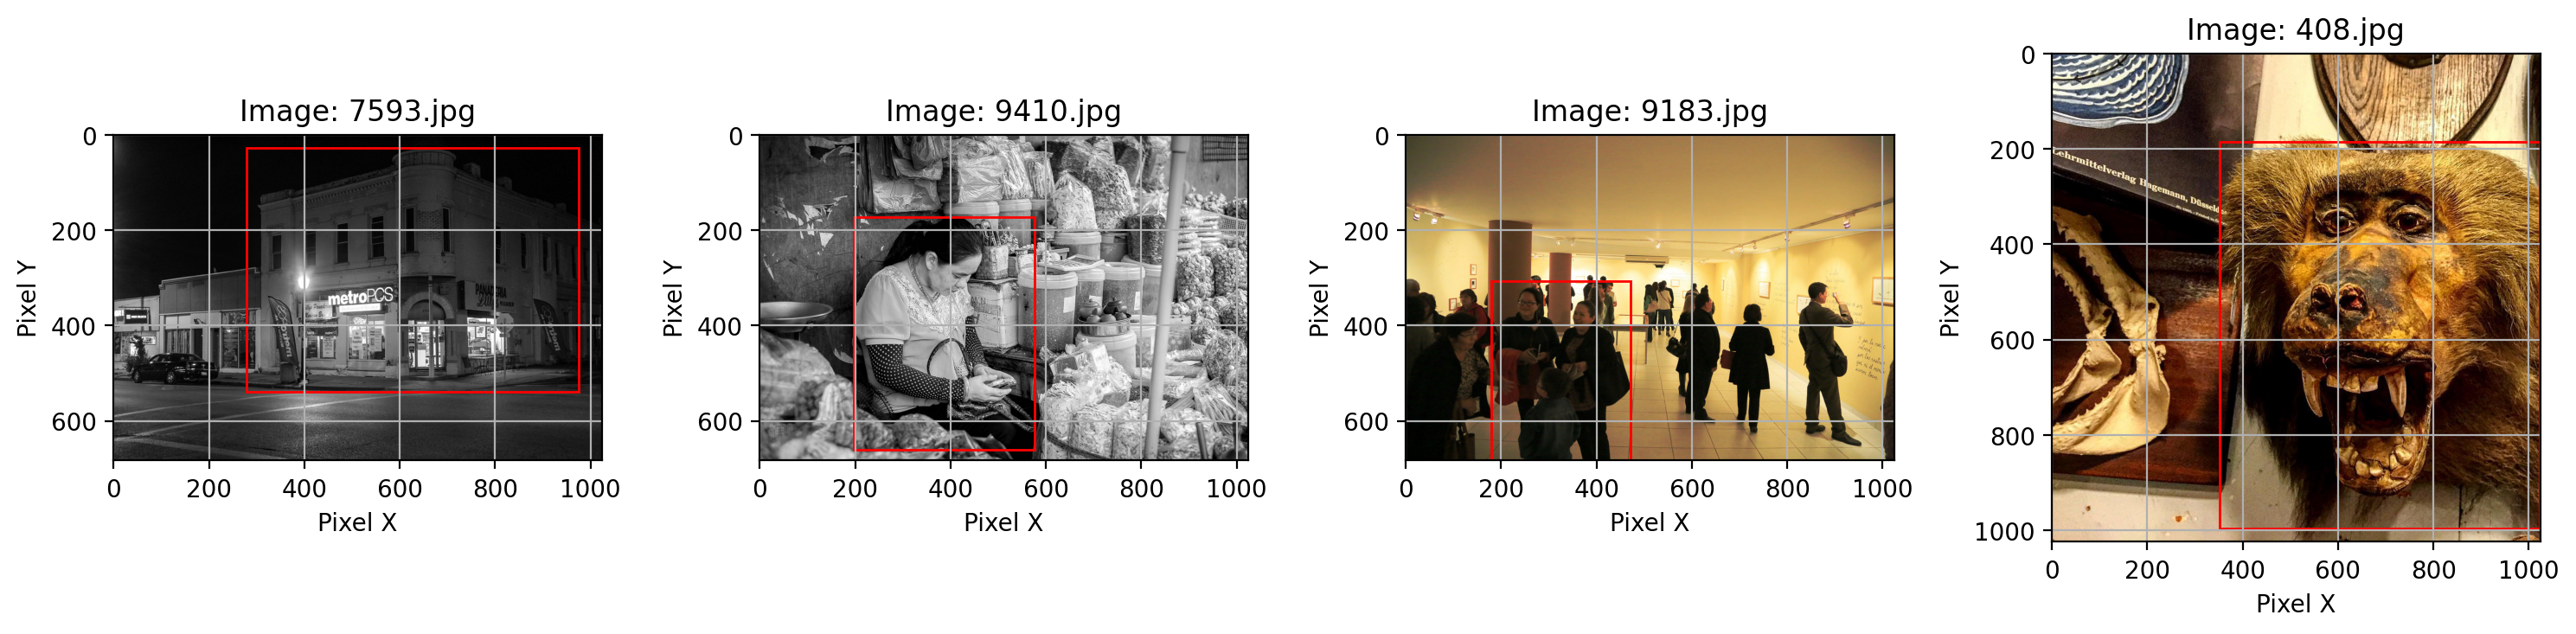

In [8]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5), dpi=200)

# Iterate through the selected sample images
for idx, (ax, (_, row)) in enumerate(zip(axs, combined_df.sample(4).iterrows())):
    img_path = f"{image_directory}{row['img']}"
    with Image.open(img_path) as img:
        ax.imshow(img)
        # Create a rectangle patch for the bounding box with edgecolor red and transparent fill
        rect = patches.Rectangle((row['rule_of_thirds_x1'], row['rule_of_thirds_y1']),
                                 row['rule_of_thirds_x2'] - row['rule_of_thirds_x1'],
                                 row['rule_of_thirds_y2'] - row['rule_of_thirds_y1'],
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.set_title(f"Image: {row['img']}")
        ax.set_xlim([0, row['width']])
        ax.set_ylim([row['height'], 0])  # Inverted to match image origin at top left
        ax.set_xlabel('Pixel X')
        ax.set_ylabel('Pixel Y')
        ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


#### Aspect Ratio

In [9]:
# The ratio of the width to the height of the image
combined_df["aspect_ratio"] = combined_df["width"] / combined_df["height"]

#### Subject positioning

In [10]:
# Calculate 'subject_size' as the area of the bounding box divided by the area of the image
combined_df['subject_size'] = ((combined_df['rule_of_thirds_x2'] - combined_df['rule_of_thirds_x1']) *
                               (combined_df['rule_of_thirds_y2'] - combined_df['rule_of_thirds_y1']) /
                               (combined_df['width'] * combined_df['height']))

# Calculate 'subject_pos_x' as the ratio of the x-coordinate of the center of the bounding box to the width
combined_df['subject_pos_x'] = ((combined_df['rule_of_thirds_x2'] + combined_df['rule_of_thirds_x1']) / 2) / combined_df['width']

# Calculate 'subject_pos_y' as the ratio of the y-coordinate of the center of the bounding box to the height
combined_df['subject_pos_y'] = ((combined_df['rule_of_thirds_y2'] + combined_df['rule_of_thirds_y1']) / 2) / combined_df['height']


#### Count of leading lines

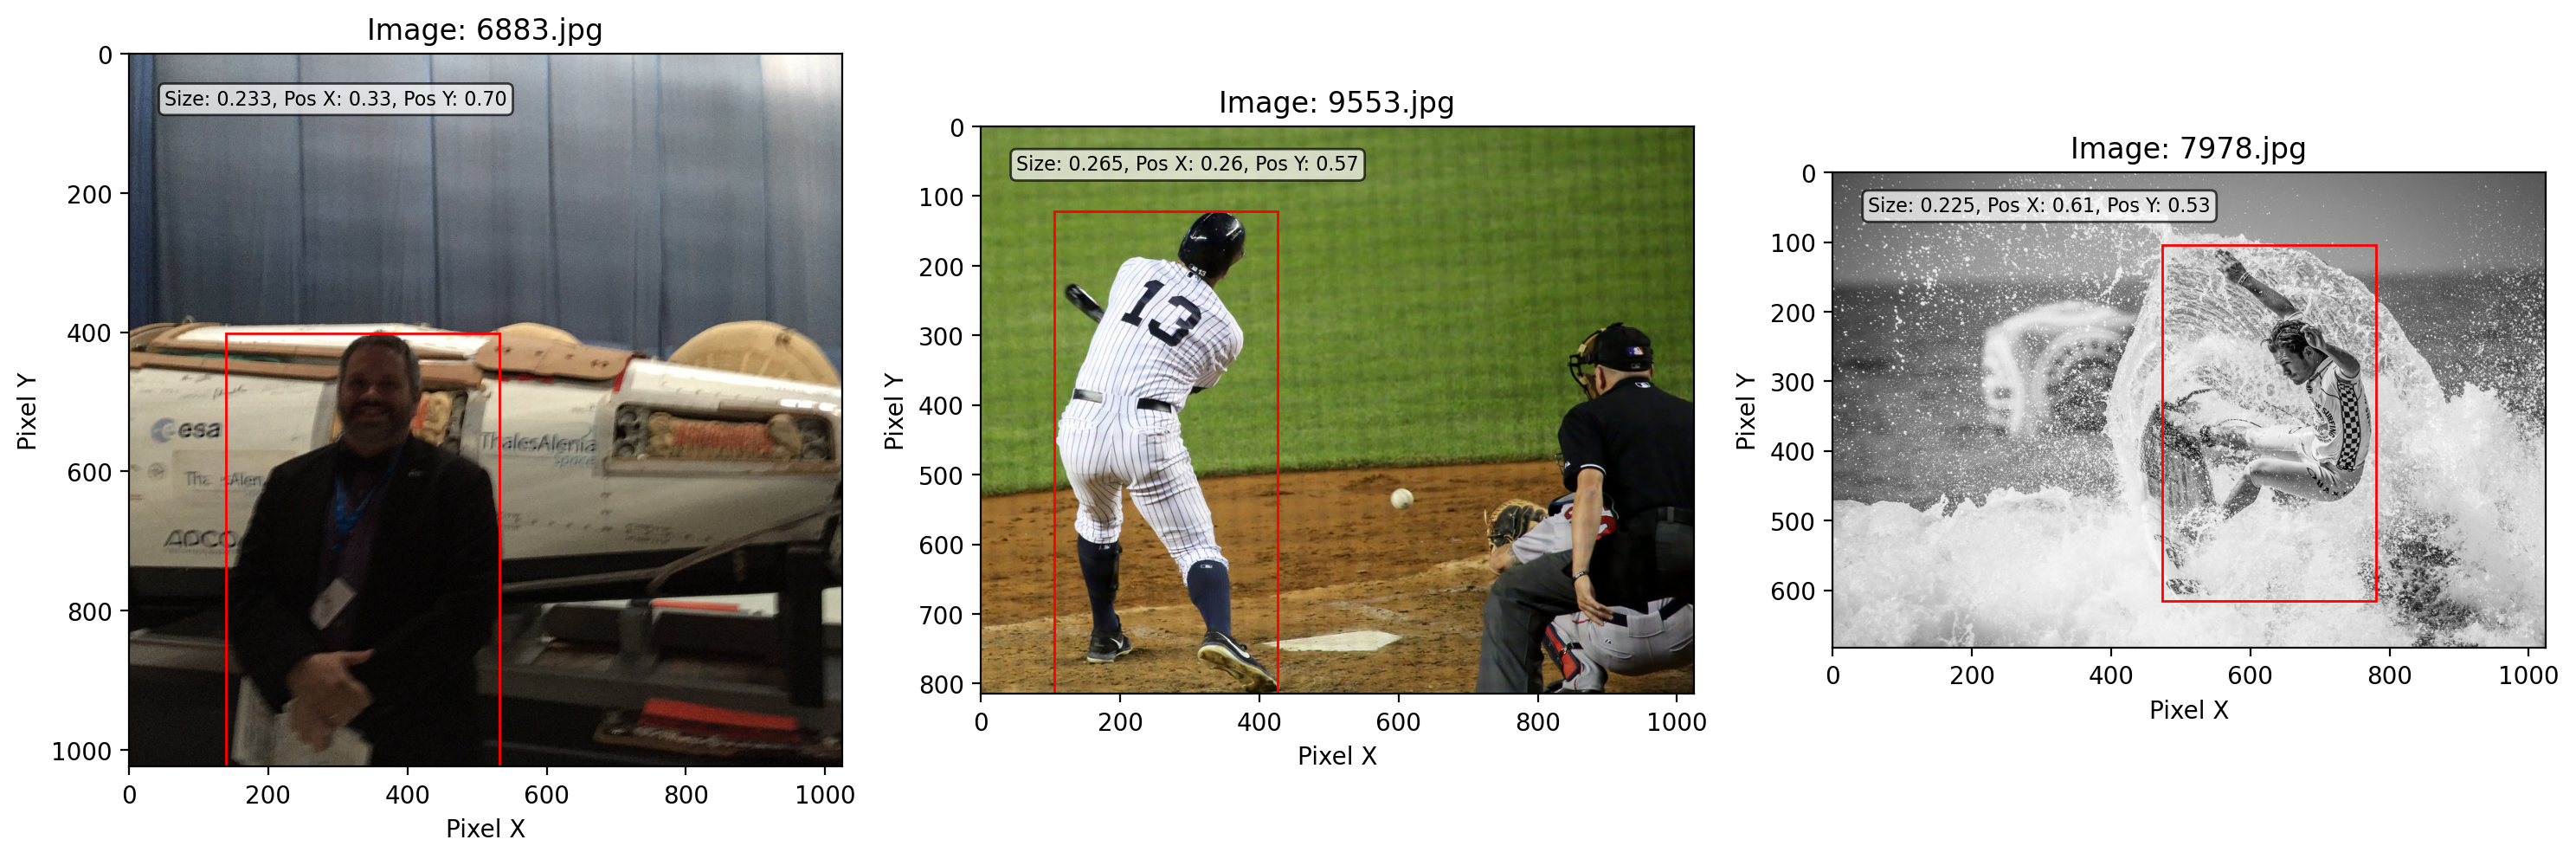

In [23]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

# Iterate through the selected sample images
for idx, (ax, (_, row)) in enumerate(zip(axs, combined_df.sample(3).iterrows())):
    img_path = f"{image_directory}{row['img']}"
    with Image.open(img_path) as img:
        ax.imshow(img)
        # Create a rectangle patch for the bounding box with edgecolor red and transparent fill
        rect = patches.Rectangle((row['rule_of_thirds_x1'], row['rule_of_thirds_y1']),
                                 row['rule_of_thirds_x2'] - row['rule_of_thirds_x1'],
                                 row['rule_of_thirds_y2'] - row['rule_of_thirds_y1'],
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Annotate image with subject size and position
        annotation_text = (f"Size: {row['subject_size']:.3f}, "
                           f"Pos X: {row['subject_pos_x']:.2f}, "
                           f"Pos Y: {row['subject_pos_y']:.2f}")
        ax.text(0.05, 0.95, annotation_text, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))
        ax.set_title(f"Image: {row['img']}")
        ax.set_xlim([0, row['width']])
        ax.set_ylim([row['height'], 0])  # Inverted to match image origin at top left
        ax.set_xlabel('Pixel X')
        ax.set_ylabel('Pixel Y')
        ax.grid(False)

# Adjust layout
plt.tight_layout()
plt.savefig('../visualizations/subject_positioning.png')
plt.show()


In [12]:
# Define a function to count the horizontal lines
def count_lines(line_string):
    if pd.isna(line_string):
        return 0
    try:
        # Safely evaluate the string as a Python literal
        line_list = ast.literal_eval(line_string)
        # If line_list is not a list but a single coordinate box, wrap it in a list
        if isinstance(line_list, tuple):
            line_list = [line_list]
        return len(line_list)  # Each box in the list is a separate line
    except (ValueError, SyntaxError):
        return 0


# Calculate number of each type of leading line in the image
combined_df['horizontal_line_count'] = combined_df['horizontal'].apply(count_lines)
combined_df['vertical_line_count'] = combined_df['vertical'].apply(count_lines)
combined_df['diagonal_line_count'] = combined_df['diagonal'].apply(count_lines)

# Sum the counts of horizontal, vertical, and diagonal lines into a new column
combined_df['leading_line_count'] = (
    combined_df['horizontal_line_count'] +
    combined_df['vertical_line_count'] +
    combined_df['diagonal_line_count']
)

#### Average angle of leading lines

In [13]:
# Correct the data structure
def correct_data_structure(row):
    if pd.notna(row):
        try:
            # Safely evaluate the string to convert it back to a list
            return ast.literal_eval(row)
        except ValueError:
            return None  # In case of a malformed string
    return None

combined_df['horizontal'] = combined_df['horizontal'].apply(correct_data_structure)
combined_df['vertical'] = combined_df['vertical'].apply(correct_data_structure)
combined_df['diagonal'] = combined_df['diagonal'].apply(correct_data_structure)


In [14]:
# Function to combine lines
def combine_lines(row):
    lines = []
    for col in ['horizontal', 'vertical', 'diagonal']:
        if isinstance(row[col], list):
            lines.extend(row[col])
    return lines

combined_df['leading_lines'] = combined_df.apply(combine_lines, axis=1)

# Function to calculate angle in degrees
def calculate_angle(x1, y1, x2, y2):
    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    return angle

# Calculate the angle for each line and average per image
def process_lines(row):
    if isinstance(row, list) and row:  # Ensure row is a non-empty list before processing
        angles = [calculate_angle(*line) for line in row if isinstance(line, list) and len(line) == 4]
        if angles:
            return np.mean(angles)
    return np.nan  # Return NaN if no valid data or empty angles list

# Apply the function to calculate average angles
combined_df['leading_lines_average_angle'] = combined_df['leading_lines'].apply(process_lines)

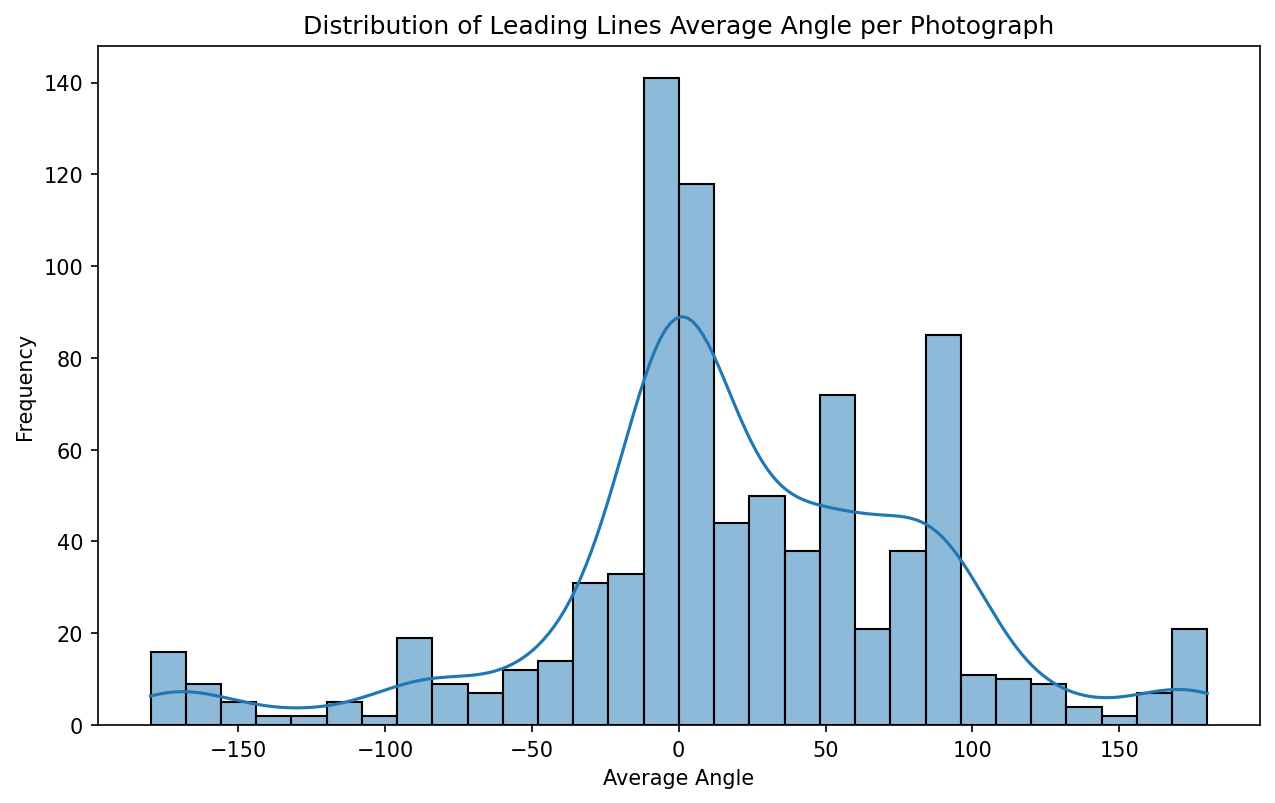

In [15]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)  # You can adjust the size as needed

# Plotting the histogram on the axes
sns.histplot(combined_df['leading_lines_average_angle'].dropna(), bins=30, ax=ax, kde=True)  # dropna to handle None values gracefully

# Set titles and labels
ax.set_title('Distribution of Leading Lines Average Angle per Photograph')
ax.set_xlabel('Average Angle')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()


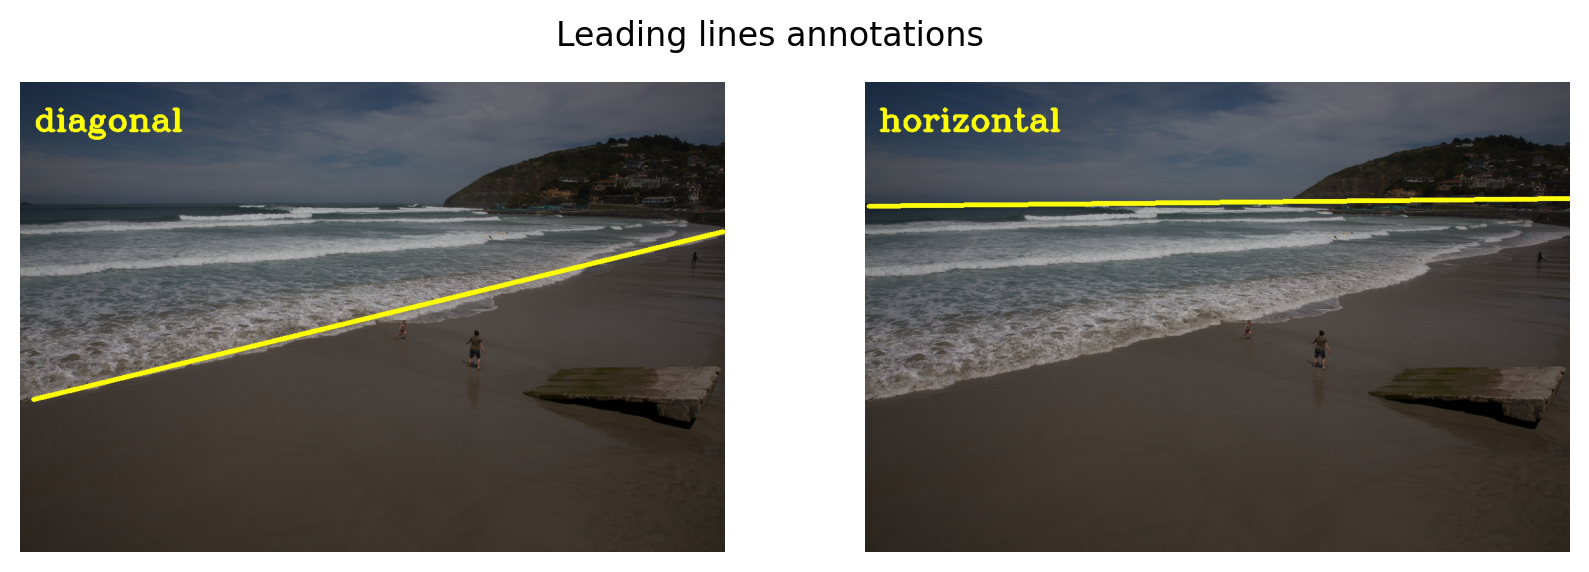

In [16]:
# Visualize leading lines annotations
# Load the images
img1 = Image.open("../data/CADB_Dataset/Visualization/composition_elements/diagonal/1513.jpg")
img2 = Image.open("../data/CADB_Dataset/Visualization/composition_elements/horizontal/1513.jpg")

# Create a figure to display the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
ax[0].imshow(img1)
ax[0].axis('off')  # Turn off axis

ax[1].imshow(img2)
ax[1].axis('off')  # Turn off axis

# Set the overall title
plt.suptitle("Leading lines annotations", y=0.8)
plt.savefig('../visualizations/leading_lines.png')
plt.show()


In [17]:
# Add engineered features to embedding df
features_df = pd.merge(features_df, combined_df[["img", "aspect_ratio", "subject_size", "subject_pos_x", "subject_pos_y", 
                                                 "horizontal_line_count", "vertical_line_count", "diagonal_line_count",
                                                 "leading_line_count", "leading_lines_average_angle"]],
                                                   on="img")
features_df.head(10)

img  aspect_ratio  subject_size  subject_pos_x  subject_pos_y  \
0  10012.jpg      0.666992      0.167974       0.742313       0.589844   
1  10016.jpg      1.499268      0.315274       0.286133       0.476574   
2  10022.jpg      1.510324      0.004840       0.336914       0.617994   
3   1004.jpg      1.499268      0.337853       0.775391       0.472914   
4   1005.jpg      1.499268      0.292414       0.827148       0.502928   
5  10054.jpg      1.499268      0.134174       0.678223       0.538799   
6  10071.jpg      0.750000      0.083633       0.791667       0.738281   
7  10090.jpg      1.499268      0.072271       0.142090       0.707174   
8  10121.jpg      1.000000      0.263391       0.293945       0.719238   
9  10122.jpg      1.759450      0.491959       0.697754       0.537801   

   horizontal_line_count  vertical_line_count  diagonal_line_count  \
0                      0                    0                    0   
1                      0                    0                    1   
2                      0                    0                    1   
3                      1                    0                    0   
4                      0                    0                    0   
5                      0                    0                    0   
6                      1                    0                    0   
7                      0                    0                    1   
8                      1                    0                    0   
9                      0                    0                    1   

   leading_line_count  leading_lines_average_angle  
0                   0                          NaN  
1                   1                   -14.313735  
2                   1                    24.969759  
3                   1                    -1.092859  
4                   0                          NaN  
5                   0                          NaN  
6                   1                     1.645118  
7                   1                  -167.034331  
8                   1                     0.969090  
9                   1                   -17.858961

### Scene class

In [18]:
# Merge features_df with the 'scene' column from combined_df
features_df = features_df.merge(combined_df[['img', 'scene']], on='img', how='left')

# Perform one-hot encoding on the 'scene_class' column
one_hot_encoded_data = pd.get_dummies(features_df['scene'], prefix='scene')

# Join the one-hot encoded columns back to the original DataFrame
features_df = pd.concat([features_df, one_hot_encoded_data], axis=1)

# Drop the original 'scene_class' column if it's no longer needed
features_df.drop('scene', axis=1, inplace=True)


### Composition attributes

In [19]:
features_df = pd.merge(features_df, combined_df[["img", "exposure", "color_vivid", "color_harmony", "object_emphasis",
                                                   "balancing_elements", "symmetry", "repetition", "rule_of_thirds",
                                                   "motion_blur", "depth_of_field"]], on="img")
features_df.head(10)

img  aspect_ratio  subject_size  subject_pos_x  subject_pos_y  \
0  10012.jpg      0.666992      0.167974       0.742313       0.589844   
1  10016.jpg      1.499268      0.315274       0.286133       0.476574   
2  10022.jpg      1.510324      0.004840       0.336914       0.617994   
3   1004.jpg      1.499268      0.337853       0.775391       0.472914   
4   1005.jpg      1.499268      0.292414       0.827148       0.502928   
5  10054.jpg      1.499268      0.134174       0.678223       0.538799   
6  10071.jpg      0.750000      0.083633       0.791667       0.738281   
7  10090.jpg      1.499268      0.072271       0.142090       0.707174   
8  10121.jpg      1.000000      0.263391       0.293945       0.719238   
9  10122.jpg      1.759450      0.491959       0.697754       0.537801   

   horizontal_line_count  vertical_line_count  diagonal_line_count  \
0                      0                    0                    0   
1                      0                    0                    1   
2                      0                    0                    1   
3                      1                    0                    0   
4                      0                    0                    0   
5                      0                    0                    0   
6                      1                    0                    0   
7                      0                    0                    1   
8                      1                    0                    0   
9                      0                    0                    1   

   leading_line_count  leading_lines_average_angle  ...  exposure  \
0                   0                          NaN  ...       0.2   
1                   1                   -14.313735  ...       0.0   
2                   1                    24.969759  ...      -0.2   
3                   1                    -1.092859  ...       0.4   
4                   0                          NaN  ...       0.0   
5                   0                          NaN  ...       0.4   
6                   1                     1.645118  ...       0.0   
7                   1                  -167.034331  ...      -0.8   
8                   1                     0.969090  ...       0.0   
9                   1                   -17.858961  ...       0.0   

   color_vivid  color_harmony  object_emphasis  balancing_elements  symmetry  \
0          0.0            0.0              0.0                -0.2       0.0   
1          0.2            0.2              0.4                 0.0       0.0   
2         -0.6            0.2             -0.2                 0.0       0.0   
3          0.0            0.6             -0.2                 0.0       0.0   
4          0.2            0.2             -0.8                 0.0       0.0   
5          0.0            0.8             -0.2                 0.4       0.0   
6          0.6            0.6              0.4                 0.2       0.0   
7         -0.4           -0.2              0.0                 0.0       0.0   
8         -0.6            0.0              0.2                 0.2       0.0   
9          0.6            0.2              0.4                 0.0       0.0   

   repetition  rule_of_thirds  motion_blur  depth_of_field  
0         0.0             0.0          0.0             0.2  
1         0.0             0.4          0.0             0.8  
2         0.0             0.2          0.0             0.2  
3         0.0            -0.4          0.0             0.0  
4         0.0             0.2          0.0             0.0  
5         0.0             0.0          0.0             0.0  
6         0.0             0.8          0.0             0.0  
7         0.2             0.4          0.0            -0.2  
8         0.0            -0.2          0.0             0.0  
9         0.0            -0.2          0.0             0.6  

[10 rows x 30 columns]

In [20]:
#Display final features for embeddings
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1291 entries, 0 to 1290
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   img                          1291 non-null   object 
 1   aspect_ratio                 1291 non-null   float64
 2   subject_size                 1291 non-null   float64
 3   subject_pos_x                1291 non-null   float64
 4   subject_pos_y                1291 non-null   float64
 5   horizontal_line_count        1291 non-null   int64  
 6   vertical_line_count          1291 non-null   int64  
 7   diagonal_line_count          1291 non-null   int64  
 8   leading_line_count           1291 non-null   int64  
 9   leading_lines_average_angle  837 non-null    float64
 10  scene_animal                 1291 non-null   uint8  
 11  scene_architecture           1291 non-null   uint8  
 12  scene_cityscape              1291 non-null   uint8  
 13  scene_human       

In [21]:
features_df.to_csv('../data/preprocessed/features_df.csv', index=False)